# Class Workbook

## In class activity

In [31]:
import numpy as np
import pandas as pd
#import math
from matplotlib.pyplot import subplots
#import statsmodels.api as sm
from plotnine import *
import plotly.express as px
#import plotly.express as px
#import statsmodels.formula.api as sm
#import ISLP as islp
from sklearn import datasets
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import geopandas as gpd
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm

### Fraud Detection

The data is synthetic datasets generated by the PaySim mobile money simulator
https://www.kaggle.com/datasets/ealaxi/paysim1

In [24]:
import zipfile
Fd= pd.read_csv('fraud.csv.gz',compression='gzip')

PaySim simulates mobile money transactions based on a sample of actual transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, the mobile financial service provider, which is currently running in more than 14 countries worldwide.  This synthetic dataset is scaled down 1/4 of the original dataset.

Here are the variables.

- step: 1 step is 1 hour. Total steps 744 (30 days simulation).
- type: CASH-IN, CASH-OUT, DEBIT, PAYMENT, and TRANSFER.
- amount: the amount of the transaction in local currency.
- nameOrig: the customer who started the transaction
- oldbalanceOrg: initial balance before the transaction
- newbalanceOrig: new balance after the transaction
- nameDest: the customer who is the recipient of the transaction
- oldbalanceDest: initial balance recipient before the transaction. Note that there is no information for customers that start with M (Merchants).
- newbalanceDest: new balance recipient after the transaction. Note that there is no information for customers that start with M (Merchants).
- isFraud: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers accounts and try to empty the funds by transferring them to another account and then cashing out of the system.
- isFlaggedFraud: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is to transfer more than 200.000 in a single transaction.

The goal of this exercise is to find ways to identify if the transaction is fraudulent.  However, pretend that you are not given `isFraud` label since, in many cases, you don't know at the time of the transaction.  You can assume you have access to `isFlaggedFraud` label at the time of your project.  Try to use the method discussed in the chapter to identify fraudulent activities.

In [25]:
Fd.head()

,Unnamed: 0,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,205,CASH_IN,412051.51,C1640117158,22382.00,434433.51,C1132673273,693342.34,281290.82,0,0
1,2,131,CASH_OUT,153341.47,C1528001478,159750.00,6408.53,C439160277,1463062.39,1616403.86,0,0
2,3,187,CASH_OUT,124480.57,C884986450,113837.06,0.00,C940878204,1151838.47,1276319.05,0,0
3,4,94,PAYMENT,1144.43,C1649289975,66119.00,64974.57,M1505288135,0.00,0.00,0,0
4,5,44,CASH_IN,72566.75,C1433714488,874229.89,946796.64,C287985544,810336.74,833260.37,0,0


In [26]:
Fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      1000 non-null   int64  
 1   step            1000 non-null   int64  
 2   type            1000 non-null   object 
 3   amount          1000 non-null   float64
 4   nameOrig        1000 non-null   object 
 5   oldbalanceOrg   1000 non-null   float64
 6   newbalanceOrig  1000 non-null   float64
 7   nameDest        1000 non-null   object 
 8   oldbalanceDest  1000 non-null   float64
 9   newbalanceDest  1000 non-null   float64
 10  isFraud         1000 non-null   int64  
 11  isFlaggedFraud  1000 non-null   int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 93.9+ KB


In [27]:
# Feature Engineering
# Creating discrepancies in balances before and after the transaction for both origin and destination
Fd['errorBalanceOrig'] = Fd['newbalanceOrig'] + Fd['amount'] - Fd['oldbalanceOrg']
Fd['errorBalanceDest'] = Fd['oldbalanceDest'] + Fd['amount'] - Fd['newbalanceDest']

In [28]:
# Exploratory Data Analysis focusing on identifying red flags for fraud
print(Fd['type'].value_counts())
print(Fd[Fd['isFlaggedFraud'] == 1].describe())

type
CASH_OUT    375
PAYMENT     328
CASH_IN     203
TRANSFER     88
DEBIT         6
Name: count, dtype: int64
       Unnamed: 0  step  amount  oldbalanceOrg  newbalanceOrig  \
count         0.0   0.0     0.0            0.0             0.0   
mean          NaN   NaN     NaN            NaN             NaN   
std           NaN   NaN     NaN            NaN             NaN   
min           NaN   NaN     NaN            NaN             NaN   
25%           NaN   NaN     NaN            NaN             NaN   
50%           NaN   NaN     NaN            NaN             NaN   
75%           NaN   NaN     NaN            NaN             NaN   
max           NaN   NaN     NaN            NaN             NaN   

       oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
count             0.0             0.0      0.0             0.0   
mean              NaN             NaN      NaN             NaN   
std               NaN             NaN      NaN             NaN   
min               NaN         

In [29]:
# Explore the distributions and relationships between amounts, balances, and errors created
high_value_threshold = Fd['amount'].quantile(0.75)  # 75th percentile as a high-value threshold
high_value_transactions = Fd[Fd['amount'] > high_value_threshold]
print(high_value_transactions[['amount', 'errorBalanceOrig', 'errorBalanceDest']].describe())

             amount  errorBalanceOrig  errorBalanceDest
count  2.500000e+02      2.500000e+02      2.500000e+02
mean   4.839740e+05      5.431701e+05      1.192799e+05
std    4.312077e+05      4.449129e+05      3.659218e+05
min    2.282891e+05      0.000000e+00     -2.774357e+06
25%    2.846465e+05      2.786429e+05      0.000000e+00
50%    3.523185e+05      3.984359e+05      0.000000e+00
75%    4.836145e+05      6.823925e+05      2.538016e+05
max    3.682533e+06      3.671436e+06      1.288877e+06


In [30]:
# Investigate `CASH_OUT` and `PAYMENT` transactions, as they are more frequent
cash_out_and_payment = Fd[Fd['type'].isin(['CASH_OUT', 'PAYMENT'])]
print(cash_out_and_payment[['amount', 'errorBalanceOrig', 'errorBalanceDest']].describe())

              amount  errorBalanceOrig  errorBalanceDest
count     703.000000        703.000000      7.030000e+02
mean   103643.789018      87704.043727     -1.204893e+04
std    129835.412078     122724.814247      1.661985e+05
min       108.350000         -0.010000     -2.774357e+06
25%      8370.120000          0.000000      0.000000e+00
50%     32511.470000      14122.840000      4.242000e+02
75%    172611.745000     154574.360000      9.097360e+03
max    755873.490000     755873.490000      6.072321e+05


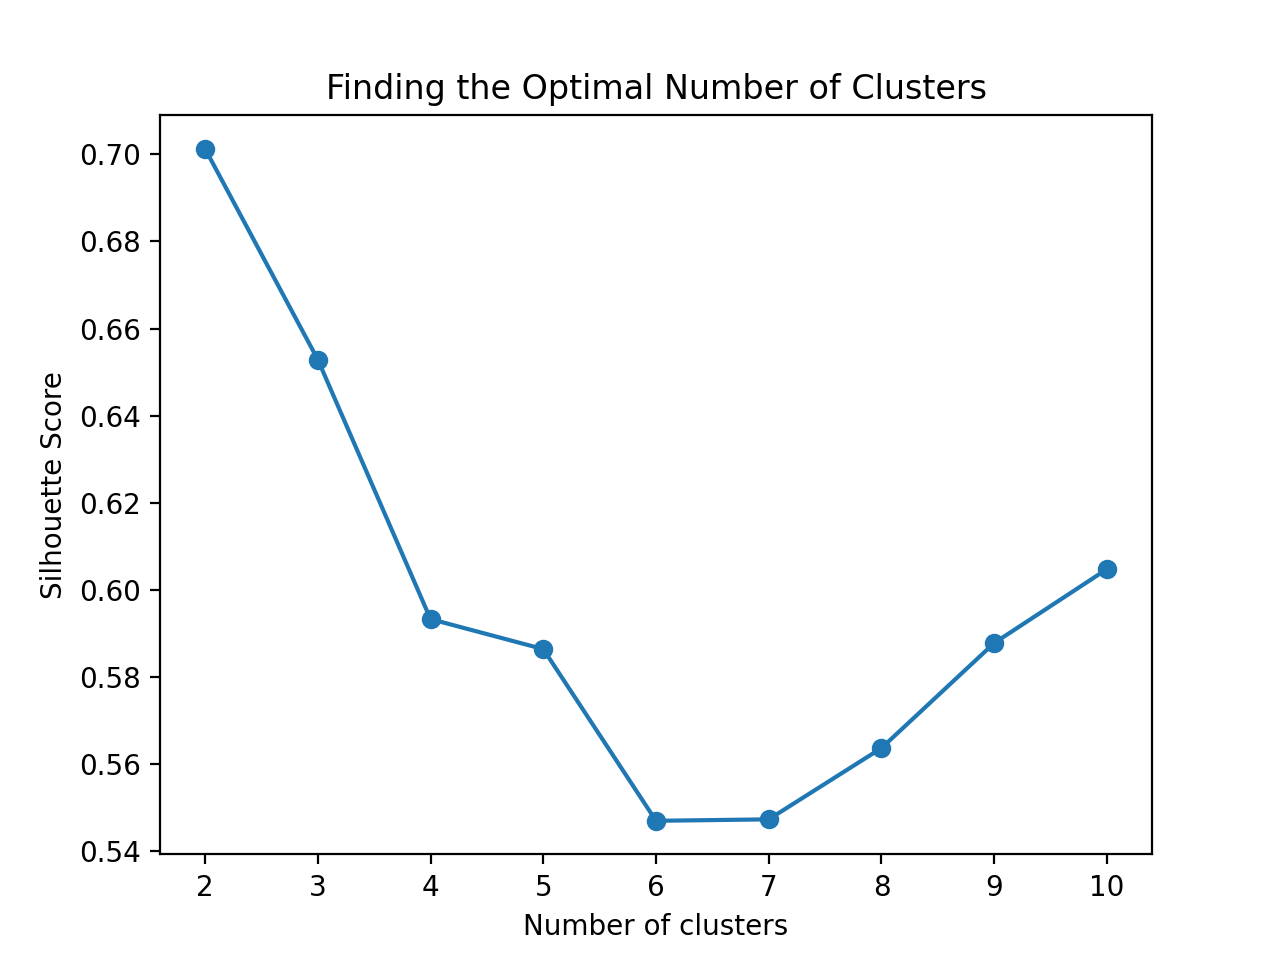

In [32]:
# Feature Selection and Preprocessing
features = Fd[['amount', 'errorBalanceOrig', 'errorBalanceDest', 'isFlaggedFraud']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Clustering with K-Means
# Determining the optimal number of clusters using silhouette score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(features_scaled)
    score = silhouette_score(features_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette scores to find the optimal k
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Finding the Optimal Number of Clusters')
plt.show()

In [33]:
optimal_k = 6
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=0)
Fd['cluster'] = kmeans_optimal.fit_predict(features_scaled)

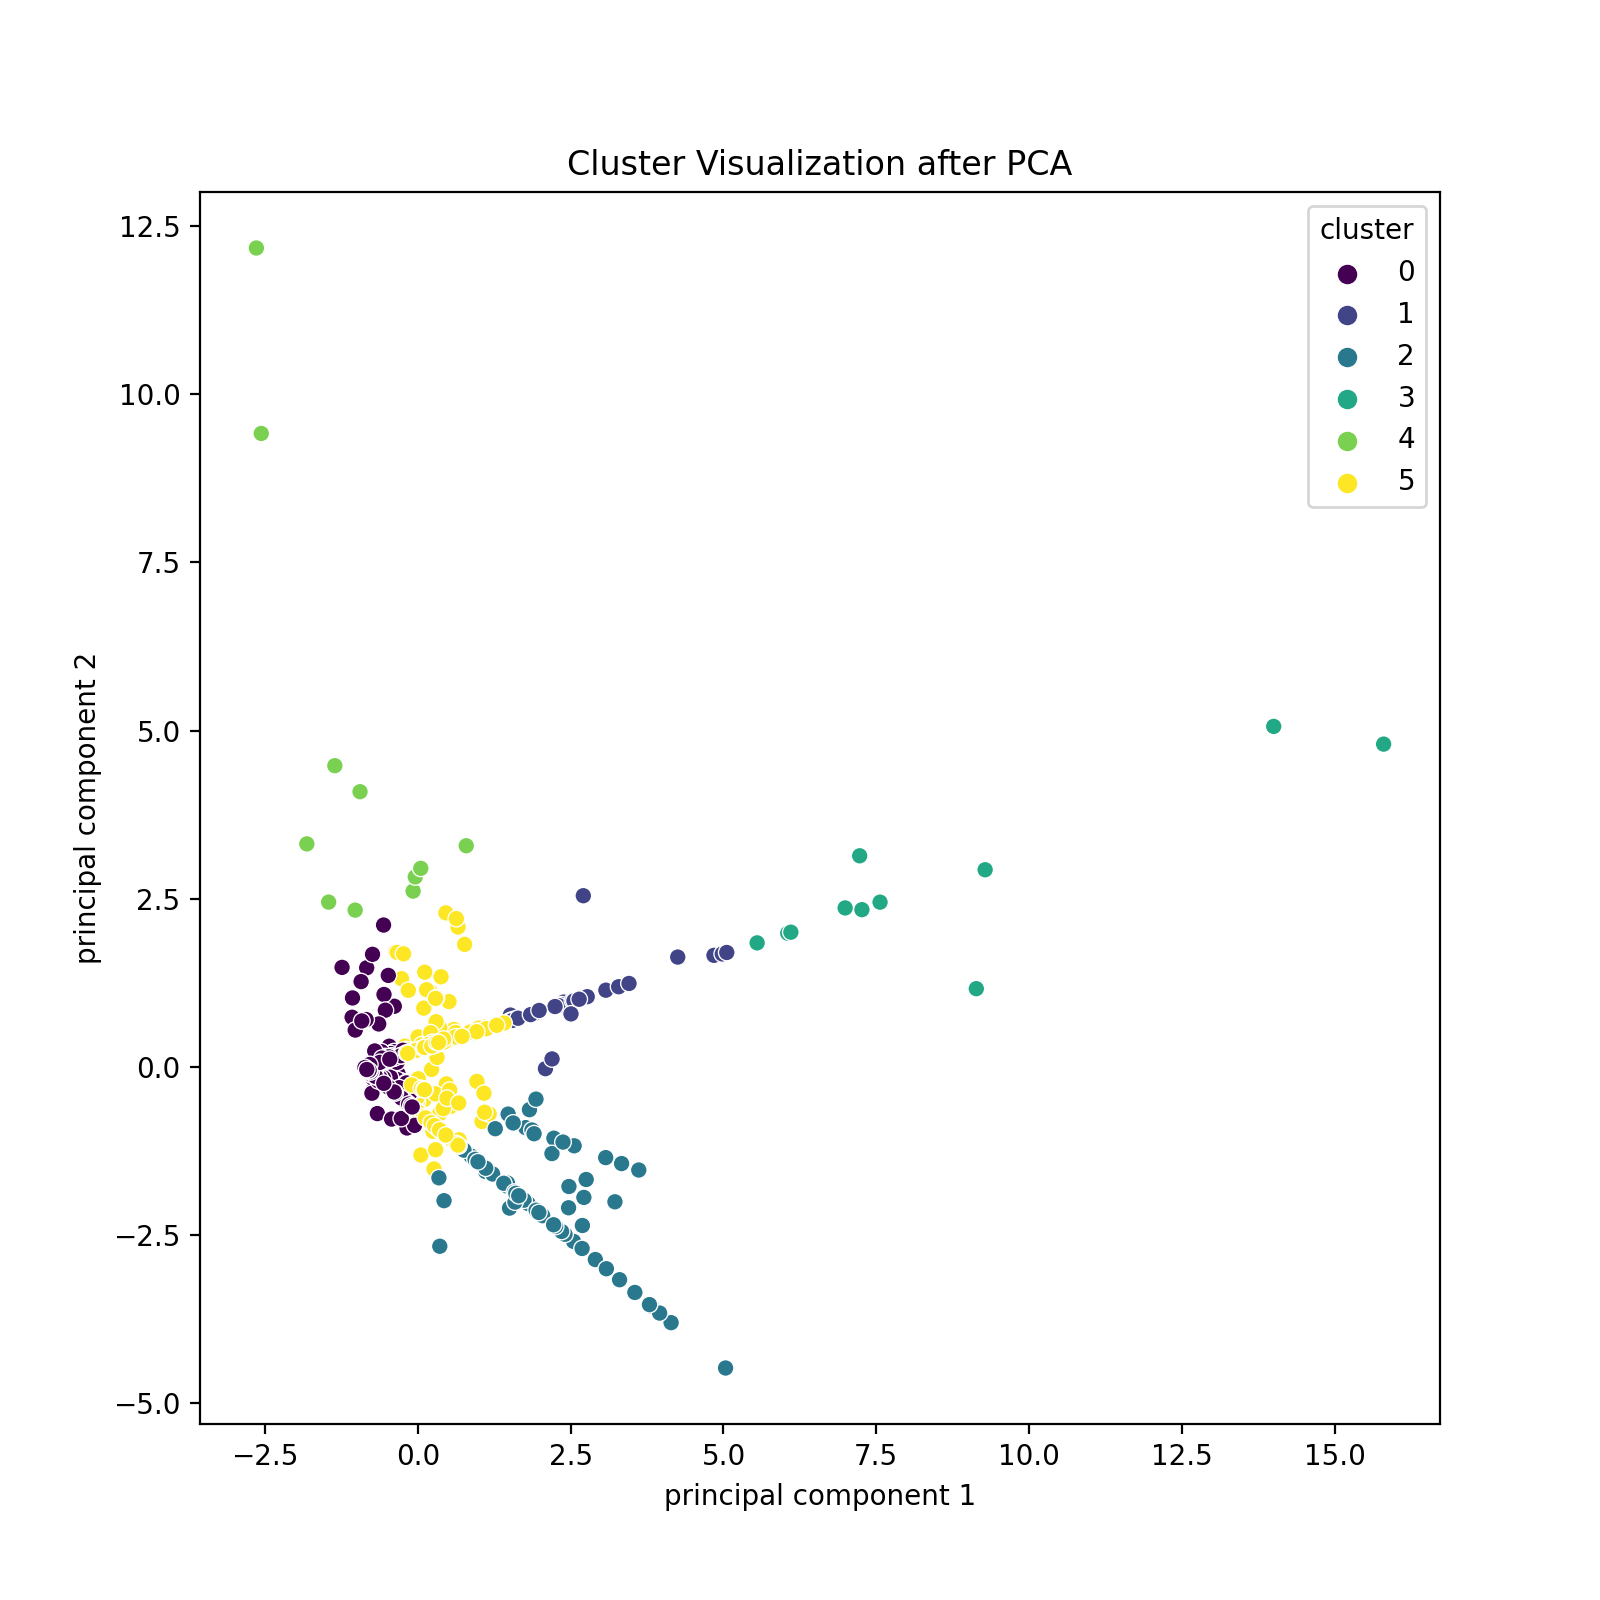

  cluster        amount                                                      \
                   mean       median            std         min         max   
0       0  3.626925e+04    14926.640   42577.656200      108.35   224895.54   
1       1  7.735110e+05   753369.190  237308.364915   410840.89  1316219.87   
2       2  3.245354e+05   316818.855  117356.406212    66004.39   644438.30   
3       3  2.075271e+06  1872362.530  729124.248782  1416695.28  3682533.20   
4       4  2.584985e+05   316547.260  165830.136849     1029.80   530926.57   
5       5  2.483297e+05   228871.020  104001.719670    92118.44   535479.96   

  errorBalanceOrig                                                     \
              mean      median            std         min         max   
0     3.070200e+04     7786.48   43625.344655       -0.01   171951.86   
1     7.470880e+05   710989.26  218101.918551   421489.48  1306820.34   
2     6.340974e+05   611820.38  239308.727222   132008.78  1288876.60   
3 

In [34]:
# PCA for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features_scaled)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, Fd[['cluster']]], axis = 1)

# Visualization
plt.figure(figsize=(8,8))
sns.scatterplot(x="principal component 1", y="principal component 2", hue="cluster", data=finalDf, palette="viridis")
plt.title('Cluster Visualization after PCA')
plt.show()

# Analyzing Clusters: Statistics for Each Cluster
cluster_stats = Fd.groupby('cluster').agg({
    'amount': ['mean', 'median', 'std', 'min', 'max'],
    'errorBalanceOrig': ['mean', 'median', 'std', 'min', 'max'],
    'errorBalanceDest': ['mean', 'median', 'std', 'min', 'max'],
    'isFlaggedFraud': 'sum'
}).reset_index()

# Displaying statistics for each cluster to identify potential anomalies
print(cluster_stats)

In [35]:
# Identify Outliers Within Clusters
# Use IQR method for 'amount' within a suspicious cluster
suspicious_cluster = Fd[Fd['cluster'] == 0]
Q1 = suspicious_cluster['amount'].quantile(0.25)
Q3 = suspicious_cluster['amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Transactions in suspicious cluster considered outliers based on 'amount'
outliers = suspicious_cluster[(suspicious_cluster['amount'] < lower_bound) | (suspicious_cluster['amount'] > upper_bound)]
print("Outliers based on amount in suspicious cluster:", outliers.shape[0])

Outliers based on amount in suspicious cluster: 33


#### Pokemon Types

Pokemon is a popular game that's been around for ages.  This data set from [Kaggle](https://www.kaggle.com/datasets/abcsds/pokemon) includes 800 Pokemon, including their number, name, first and second type, and basic stats: HP, Attack, Defense, Special Attack, Special Defense, and Speed.

(ID)#: ID for each pokemon
Name: Name of each pokemon
Type 1: Each pokemon has a type, this determines weakness/resistance to attacks
Type 2: Some pokemon are dual type and have 2
Total: sum of all stats that come after this, a general guide to how strong a pokemon is
HP: hit points, or health, defines how much damage a pokemon can withstand before fainting
Attack: the base modifier for normal attacks (eg. Scratch, Punch)
Defense: the base damage resistance against normal attacks
SP Atk: special attack, the base modifier for special attacks (e.g. fire blast, bubble beam)
SP Def: the base damage resistance against special attacks
Speed: determines which pokemon attacks first each round

In [ ]:
Pokemon = pd.read_csv('Pokemon.csv')

Do EDA and find patterns in the data. Notice that this data is multivariate, with some clear dependency in the variables. Does the result make sense?

In [ ]:
#
#

Comment of the result:

~~~
Please write your answer in full sentences.


~~~

Your task is to group the Pokemon into some meaningful clusters that makes sense to you and have a discussion with your neighbor on why your clusters make the most sense. How many cluster seems appropriate?

In [ ]:
#
#

Comment of the result:

~~~
Please write your answer in full sentences.


~~~

Look at your cluster and see if you can identify a monster that does not seem to fit with the other monsters. Why do you think that might be?  If you want to know more about these Pokemons you can do a deeper dive by looking through the [database](https://pokemondb.net/pokedex/all).

In [ ]:
#
#

Comment of the result:

~~~
Please write your answer in full sentences.


~~~

### Image cluster

Let's look at Fashion MNIST data.
https://www.kaggle.com/datasets/zalando-research/fashionmnist

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), representing the clothing article. The rest of the columns contain the pixel-values of the associated image.

In [10]:
fm=pd.read_csv('fashion-mnist_train_sub.csv')

- Each row in the data is a separate image.
- Remaining columns are pixel numbers (784 total).  To locate a pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27. The pixel is located on row i and column j of a 28 x 28 matrix. For example, pixel31 indicates the pixel in the fourth column from the left, and the second row from the top.
- Each value is the darkness of the pixel (1 to 255)
- Column 1 is the class label ( which we will assume is not given )
  0 T-shirt/top
  1 Trouser
  2 Pullover
  3 Dress
  4 Coat
  5 Sandal
  6 Shirt
  7 Sneaker
  8 Bag
  9 Ankle boot

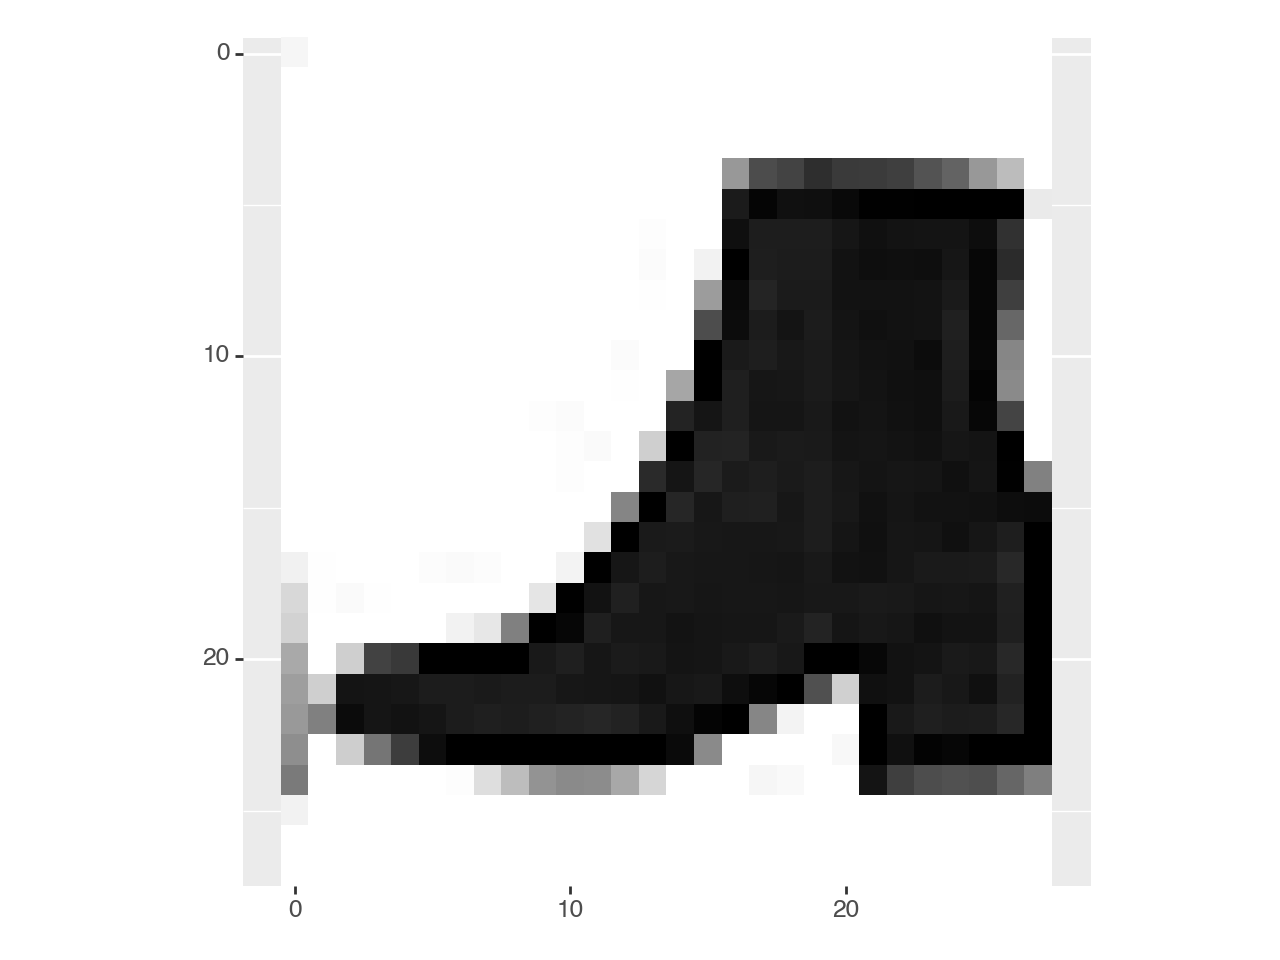

<Figure Size: (640 x 480)>

In [11]:
xrange = np.arange(0, 28, 1)
yrange = np.arange(0, 28, 1)
xx, yy = np.meshgrid(xrange, yrange)
gmat = pd.DataFrame({'x':xx.ravel(),'y':yy.ravel()})

# df1.reset_index(drop=True, inplace=True)
# df2.reset_index(drop=True, inplace=True)
#
# df = pd.concat([df1, df2], axis=1)
tempimg=fm.iloc[3,1:785]
tempimg.reset_index(drop=True, inplace=True)
ptdf=pd.concat([gmat["x"],gmat["y"],tempimg], names=['x','y', 'value'], axis=1)
ptdf.columns =["x","y","value"]
(
ggplot(ptdf) +
  geom_raster(aes(x = "x", y = "y", fill = "value")) +
  scale_fill_gradient(low = "white", high = "black") +
  theme(aspect_ratio = 1, legend_position = "none") +
  labs(x = "", y = "") +
  scale_y_reverse( expand = (0, 0))
)

## Problem Set

### Euclidian distance and Correlation

In the chapter, we mentioned the use of correlation-based distance and Euclidean distance as dissimilarity measures for hierarchical clustering. It turns out that these two measures are almost equivalent: if each observation has been centered to have mean zero and standard deviation one, and if we let $r_{ij}$ denote the correlation between the ith and jth observations, then the quantity $1-r_{ij}$ is proportional to the squared Euclidean distance between the ith and jth observations. On the `USArrests` data, show that this proportionality holds.

Hint: The Euclidean distance can be calculated using the `pairwise_distances()` function from the `sklearn.metrics` module, and correlations can be calculated using the `np.corrcoef()` function.

### Percent Variance Explained

A formula for calculating PVE was given as
$$\frac{\sum_i^n z_{im}^2}{\sum_j^p\sum_i^n x_{ij}^2}=\frac{\sum_i^n (\sum_j^p\phi_{jm}x_{ij}    )^2}{\sum_j^p\sum_i^n x_{ij}^2}$$
We also saw that the PVE can be obtained using the `explained_variance_ratio_` attribute of a fitted `PCA()` estimator.
On the `USArrests` data, calculate PVE in two ways:

(a) Using the `explained_variance_ratio_` output of the fitted `PCA()` estimator, as was done in Section 12.2.3.
(b) By applying Equation 12.10 directly. The loadings are stored as the `components_` attribute of the fitted `PCA()` estimator. Use those loadings in Equation 12.10 to obtain the PVE.

Hint: You will only obtain the same results in (a) and (b) if the same
data is used in both cases. For instance, if in (a) you performed PCA()
using centered and scaled variables, then you must center and scale
the variables before applying Equation 12.10 in (b).

### Hierarchical clustering of USA Arrest

Consider the `USArrests` data. We will now perform hierarchical clustering on the states.
(a) Using hierarchical clustering with complete linkage and Euclidean distance, cluster the states.

Your code:

In [14]:
USArrests = pd.read_csv("USArrests.csv", index_col = 0)

In [15]:
USArrests.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


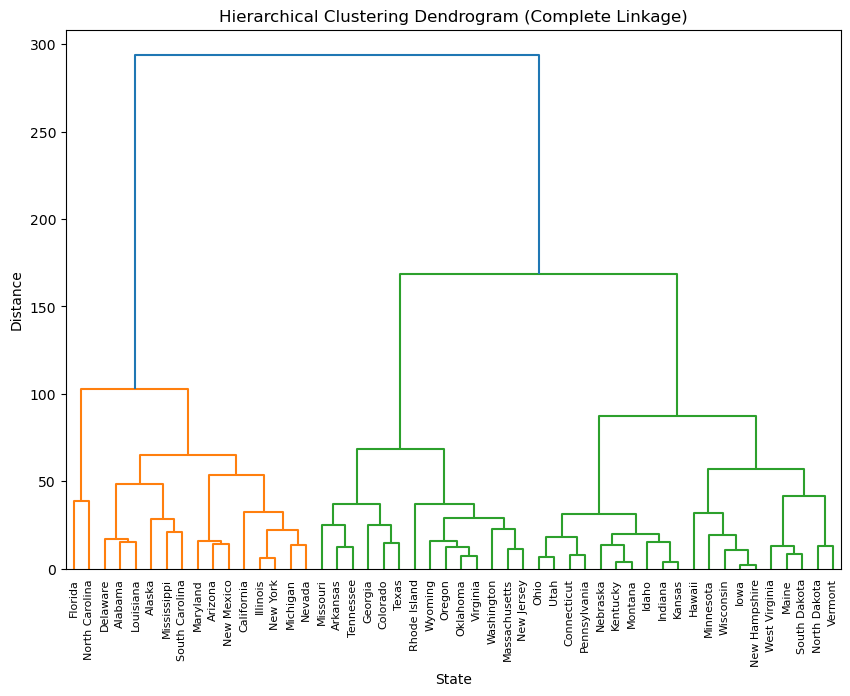

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Hierarchical clustering using complete linkage and Euclidean distance
Z = linkage(USArrests, 'complete')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=USArrests.index)
plt.title('Hierarchical Clustering Dendrogram (Complete Linkage)')
plt.xlabel('State')
plt.ylabel('Distance')
plt.show()

Your answer:

~~~
Please write your answer in full sentences.


~~~

(b) Cut the dendrogram at a height that results in three distinct clusters. Which states belong to which clusters?

Your code:

In [18]:
# Cut the dendrogram
clusters = fcluster(Z, 3, criterion='maxclust')

# DataFrame maps each state to its cluster
state_clusters = pd.DataFrame({'State': USArrests.index, 'Cluster': clusters})

for cluster_num in sorted(state_clusters['Cluster'].unique()):
    print(f"Cluster {cluster_num}:")
    print(state_clusters[state_clusters['Cluster'] == cluster_num]['State'].to_list())
    print("\n")

Cluster 1:
['Alabama', 'Alaska', 'Arizona', 'California', 'Delaware', 'Florida', 'Illinois', 'Louisiana', 'Maryland', 'Michigan', 'Mississippi', 'Nevada', 'New Mexico', 'New York', 'North Carolina', 'South Carolina']


Cluster 2:
['Arkansas', 'Colorado', 'Georgia', 'Massachusetts', 'Missouri', 'New Jersey', 'Oklahoma', 'Oregon', 'Rhode Island', 'Tennessee', 'Texas', 'Virginia', 'Washington', 'Wyoming']


Cluster 3:
['Connecticut', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'North Dakota', 'Ohio', 'Pennsylvania', 'South Dakota', 'Utah', 'Vermont', 'West Virginia', 'Wisconsin']




Your answer:

~~~
Please write your answer in full sentences.


~~~

(c) Hierarchically cluster the states using complete linkage and Euclidean distance, after scaling the variables to have standard deviation one.

Your code:

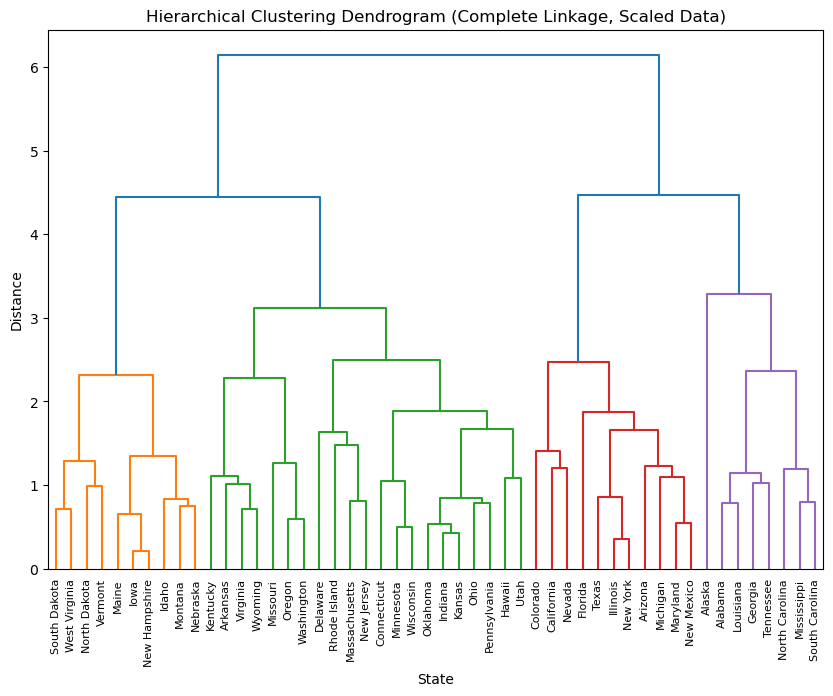

In [21]:
# Scale the variables to have standard deviation one
scaler = StandardScaler()
USArrests_scaled = scaler.fit_transform(USArrests)

# Hierarchical clustering using complete linkage and Euclidean distance
Z_scaled = linkage(USArrests_scaled, 'complete')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z_scaled, labels=USArrests.index)
plt.title('Hierarchical Clustering Dendrogram (Complete Linkage, Scaled Data)')
plt.xlabel('State')
plt.ylabel('Distance')
plt.show()

Your answer:

~~~
Please write your answer in full sentences.


~~~

(d) What effect does scaling the variables have on the hierarchical clustering obtained? In your opinion, should the variables be scaled before the inter-observation dissimilarities are computed? Provide a justification for your answer.

Your code:

Your answer:

~~~
In my opinion, scaling variables before hierarchical clustering ensures each variable equally influences the analysis. Therefore, the variables should be scaled before computing the inter-observation dissimilarities.

In the context of the USArrests dataset, the variables are measured on different scales and have different ranges of values. Without scaling, variables with larger ranges and variances can disproportionately influence the distance calculations, potentially overshadowing the contributions of variables with smaller ranges.
~~~

### Simulation PCA and Kmeans

In this problem, you will generate simulated data, and then perform PCA and K-means clustering on the data.

(a) Generate a simulated data set with 20 observations in each of
three classes (i.e. 60 observations total), and 50 variables.
Hint: There are a number of functions in Python that you can
use to generate data. One example is the normal() method of
the random() function in numpy; the uniform() method is another
option. Be sure to add a mean shift to the observations in each
class so that there are three distinct classes.
Your code:

In [3]:
np.random.seed(1)

# 20 observations; three classes; 50 variables
n_obs = 20
n_vars = 50
n_classes = 3

# Initialize an empty array
data = np.empty((n_obs * n_classes, n_vars))

# Generate data
for i in range(n_classes):
    # Mean shift
    data[i*n_obs:(i+1)*n_obs, :] = np.random.normal(loc=i, scale=1, size=(n_obs, n_vars))

df = pd.DataFrame(data)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.624345,-0.611756,-0.528172,-1.072969,0.865408,-2.301539,1.744812,-0.761207,0.319039,-0.249370,...,-0.191836,-0.887629,-0.747158,1.692455,0.050808,-0.636996,0.190915,2.100255,0.120159,0.617203
1,0.300170,-0.352250,-1.142518,-0.349343,-0.208894,0.586623,0.838983,0.931102,0.285587,0.885141,...,1.198918,0.185156,-0.375285,-0.638730,0.423494,0.077340,-0.343854,0.043597,-0.620001,0.698032
2,-0.447129,1.224508,0.403492,0.593579,-1.094912,0.169382,0.740556,-0.953701,-0.266219,0.032615,...,-0.186570,-0.101746,0.868886,0.750412,0.529465,0.137701,0.077821,0.618380,0.232495,0.682551
3,-0.310117,-2.434838,1.038825,2.186980,0.441364,-0.100155,-0.136445,-0.119054,0.017409,-1.122019,...,1.160339,0.369493,1.904659,1.111057,0.659050,-1.627438,0.602319,0.420282,0.810952,1.044442
4,-0.400878,0.824006,-0.562305,1.954878,-1.331952,-1.760689,-1.650721,-0.890556,-1.119115,1.956079,...,-0.498214,-0.310985,-0.001891,-1.396620,-0.861316,0.674712,0.618539,-0.443172,1.810535,-1.305727


Your answer:

~~~
Please write your answer in full sentences.


~~~

(b) Perform PCA on the 60 observations and plot the first two principal
component score vectors. Use a different color to indicate
the observations in each of the three classes. If the three classes
appear separated in this plot, then continue on to part (c). If
not, then return to part (a) and modify the simulation so that
there is greater separation between the three classes. Do not
continue to part (c) until the three classes show at least some
separation in the first two principal component score vectors.

Your code:

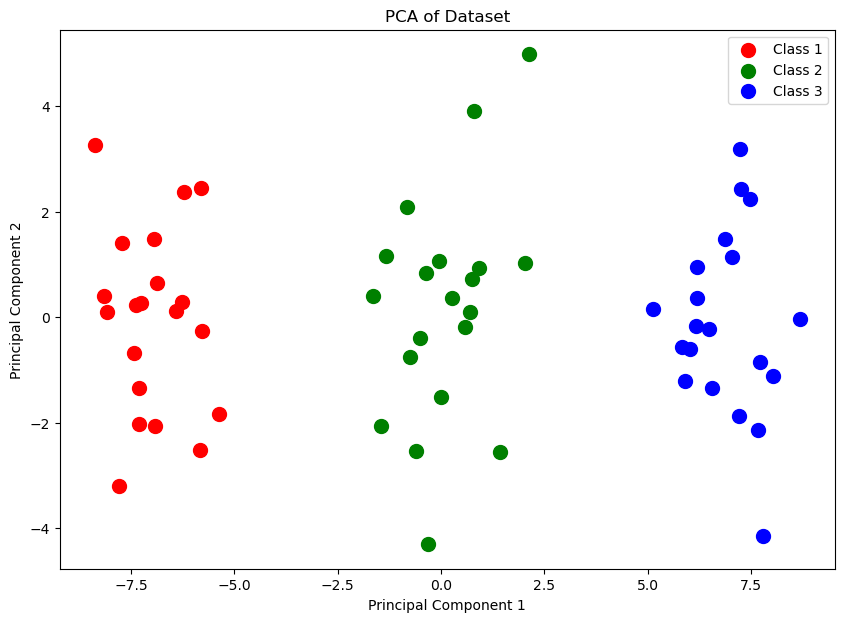

In [4]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Add a class label
principal_df['Class'] = np.repeat(['Class 1', 'Class 2', 'Class 3'], n_obs)

# Plot
plt.figure(figsize=(10, 7))
colors = ['r', 'g', 'b']
for color, label in zip(colors, ['Class 1', 'Class 2', 'Class 3']):
    subset = principal_df[principal_df['Class'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], s=100, c=color, label=label)

plt.title('PCA of Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

Your answer:

~~~
Please write your answer in full sentences.


~~~

(c) Perform K-means clustering of the observations with K = 3.
How well do the clusters that you obtained in K-means clustering
compare to the true class labels?
Hint: You can use the pd.crosstab() function in Python to compare
the true class labels to the class labels obtained by clustering.
Be careful how you interpret the results: K-means clustering
will arbitrarily number the clusters, so you cannot simply check
whether the true class labels and clustering labels are the same.
Your code:

In [5]:
# K-means clustering with K=3
kmeans = KMeans(n_clusters=3, random_state=0).fit(df)

# Extract the cluster labels from K-means
cluster_labels = kmeans.labels_

# True class labels
true_labels = np.repeat([0, 1, 2], n_obs)

# Compare the true class labels to the class labels obtained by clustering
comparison = pd.crosstab(true_labels, cluster_labels, rownames=['True Labels'], colnames=['Cluster Labels'])
comparison

Cluster Labels,0,1,2
True Labels,,,
0,0,0,20
1,20,0,0
2,0,20,0


Your answer:

~~~
Cluster 0 corresponds to all observations from True Label 1.
Cluster 1 corresponds to all observations from True Label 2.
Cluster 2 corresponds to all observations from True Label 0.

This means that the K-means clustering perfectly matched the true class labels, considering the arbitrary numbering of clusters by K-means.
~~~


(d) Perform K-means clustering with K = 2. Describe your results.
Your code:

In [6]:
# K-means clustering with K=2
kmeans_2 = KMeans(n_clusters=2, random_state=0).fit(df)

# Extract the cluster labels from K-means
cluster_labels_2 = kmeans_2.labels_

# Compare the true class labels to the class labels obtained by clustering
comparison_2 = pd.crosstab(true_labels, cluster_labels_2, rownames=['True Labels'], colnames=['Cluster Labels'])
comparison_2

Cluster Labels,0,1
True Labels,,
0,20,0
1,12,8
2,0,20


Your answer:

~~~
True Label 0 is entirely grouped into Cluster Label 0.
True Label 1 is split between both clusters, with 12 observations in Cluster Label 0 and 8 in Cluster Label 1.
True Label 2 is entirely grouped into Cluster Label 1.

This indicates that the clustering algorithm clearly separates True Label 0 and True Label 2 into two distinct clusters. However, True Label 1's observations are seen as somewhat intermediate between these two groups, with a majority being closer to True Label 0's cluster and a minority being closer to True Label 2's cluster. This outcome suggests that while True Labels 0 and 2 are distinct enough to be completely separated by K-means, True Label 1 shares similarities with both other classes, leading to its split across the two clusters.
~~~

(e) Now perform K-means clustering with K = 4, and describe your results.

Your code:

In [7]:
# K-means clustering with K=4
kmeans_4 = KMeans(n_clusters=4, random_state=0).fit(df)

# Extract the cluster labels from K-means
cluster_labels_4 = kmeans_4.labels_

# Compare the true class labels to the class labels obtained by clustering
comparison_4 = pd.crosstab(true_labels, cluster_labels_4, rownames=['True Labels'], colnames=['Cluster Labels'])
comparison_4

Cluster Labels,0,1,2,3
True Labels,,,,
0,0,0,20,0
1,5,0,0,15
2,0,20,0,0


Your answer:

~~~
True Label 0's observations are entirely placed in Cluster Label 2.
True Label 1's observations are divided between Cluster Labels 0 and 3, with 5 observations in Cluster Label 0 and 15 in Cluster Label 3.
True Label 2's observations are entirely placed in Cluster Label 1.

This outcome indicates that K-means clustering with K=4 is able to distinctly separate the observations of True Label 0 and True Label 2 into their own clusters. However, it also shows that the observations from True Label 1 are split between two clusters, suggesting variations within this group that the algorithm detects as significant enough to warrant separate clusters. True Label 1's split might reflect underlying subgroups or a spread of data points that overlaps with the space defined by other clusters.
~~~

(f) Now perform K-means clustering with K = 3 on the first two
principal component score vectors, rather than on the raw data.
That is, perform K-means clustering on the 60 × 2 matrix of
which the first column is the first principal component score
vector, and the second column is the second principal component
score vector. Comment on the results.

Your code:

In [8]:
# K-means clustering with K=3 on the reduced data (first two principal components)
kmeans_pca = KMeans(n_clusters=3, random_state=0).fit(principal_components)

# Extract the cluster labels from K-means
cluster_labels_pca = kmeans_pca.labels_

# Compare the true class labels to the class labels obtained by clustering
comparison_pca = pd.crosstab(true_labels, cluster_labels_pca, rownames=['True Labels'], colnames=['Cluster Labels PCA'])
comparison_pca

Cluster Labels PCA,0,1,2
True Labels,,,
0,0,0,20
1,20,0,0
2,0,20,0


Your answer:

~~~
True Label 0 is perfectly clustered into Cluster Label 2.
True Label 1 is perfectly clustered into Cluster Label 0.
True Label 2 is perfectly clustered into Cluster Label 1.

This result indicates an excellent clustering performance. It demonstrates the effectiveness of using PCA for dimensionality reduction before clustering, as it captures the most significant variance and patterns in the data, facilitating clear and distinct clustering aligned with the true underlying structure.
~~~

(g) Using the StandardScaler() estimator, perform K-means clustering
with K = 3 on the data after scaling each variable to have
standard deviation one. How do these results compare to those
obtained in (b)? Explain.

Your code:

In [9]:
# StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# K-means clustering with K=3 on the scaled data
kmeans_scaled = KMeans(n_clusters=3, random_state=0).fit(scaled_data)

# Extract the cluster labels from K-means
cluster_labels_scaled = kmeans_scaled.labels_

# Compare the true class labels to the class labels obtained by clustering
comparison_scaled = pd.crosstab(true_labels, cluster_labels_scaled, rownames=['True Labels'], colnames=['Cluster Labels Scaled'])
comparison_scaled

Cluster Labels Scaled,0,1,2
True Labels,,,
0,20,0,0
1,0,0,20
2,0,20,0


Your answer:

~~~
All observations from True Label 0 are grouped into Cluster Label 0.
All observations from True Label 1 are grouped into Cluster Label 2.
All observations from True Label 2 are grouped into Cluster Label 1.

These results again show an excellent clustering performance. The success of the standardization approach here indicates that scaling did not negatively impact the ability to distinguish between the classes, suggesting that the original variables likely had similar scales or that the class differences were pronounced enough to be captured even after standardization.
~~~

### Matrix completion

Write a Python function to perform matrix completion as in Algorithm
12.1, and as outlined in Section 12.5.2. In each iteration, the
function should keep track of the relative error, as well as the iteration
count. Iterations should continue until the relative error is small
enough or until some maximum number of iterations is reached (set a
default value for this maximum number). Furthermore, there should
be an option to print out the progress in each iteration.
Test your function on the Boston data. First, standardize the features
to have mean zero and standard deviation one using the
`StandardScaler()` function. Run an experiment where you randomly
leave out an increasing (and nested) number of observations from 5%
to 30%, in steps of 5%. Apply Algorithm 12.1 with $M = 1, 2,\dots, 8$.
Display the approximation error as a function of the fraction of observations
that are missing, and the value of M, averaged over 10
repetitions of the experiment.

Your code:

In [ ]:
# Challenging

Your answer:

~~~
Please write your answer in full sentences.


~~~

### Matrix completion


In Section 12.5.2, Algorithm 12.1 was implemented using the
svd() function from the np.linalg module. However, given the connection
between the svd() function and the PCA() estimator highlighted
in the lab, we could have instead implemented the algorithm
using PCA().
Write a function to implement Algorithm 12.1 that makes use of PCA()
rather than svd().

Your code:

In [12]:
def matrix_completion_pca(X, M, max_iter=1000, tol=1e-4, print_progress=False):
    n, p = X.shape
    X_filled = X.copy()
    X_mask = np.isnan(X_filled)
    
    # Initialize missing values with column means
    for j in range(p):
        X_filled[X_mask[:, j], j] = np.mean(X_filled[~X_mask[:, j], j])
    
    iter_count = 0
    objective = np.inf

    while iter_count < max_iter:
        X_old = X_filled.copy()

        # Apply PCA to the filled matrix
        pca = PCA(n_components=M)
        pca.fit(X_filled)
        X_reduced = pca.transform(X_filled)  # Get the reduced matrix
        X_filled = pca.inverse_transform(X_reduced)  # Inverse transform to get the approximation

        # Update the missing entries only
        X_filled[X_mask] = X_old[X_mask]

        # Compute the objective
        old_objective = objective
        objective = np.sum((X_filled[~X_mask] - X[~X_mask]) ** 2)

        # Check for convergence
        relative_error = np.abs(objective - old_objective) / (old_objective if old_objective != 0 else 1)
        if print_progress:
            print(f'Iteration {iter_count}, Objective: {objective}, Relative Error: {relative_error}')
        
        if relative_error < tol:
            break

        iter_count += 1

    return X_filled, iter_count, objective

Your answer:

~~~
Please write your answer in full sentences.


~~~

### Gene expression

The dataset on gene expression (Ch12Ex13.csv) consists of 40 tissue samples with measurements on 1,000 genes. The first 20 samples are from healthy patients, while the second 20 are from a diseased group.

(a) Load in the data using pd.read_csv(). You will need to select `header = None`.

Your code:

In [16]:
credit_data = pd.read_csv("Ch12Ex13.csv", header = None)

In [17]:
credit_data.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.961933,0.441803,-0.975005,1.417504,0.818815,0.316294,-0.024967,-0.063966,0.031497,-0.350311,...,-0.509591,-0.216725,-0.055506,-0.484449,-0.521581,1.949135,1.324335,0.468147,1.061100,1.655970
1,-0.292526,-1.139267,0.195837,-1.281121,-0.251439,2.511997,-0.922206,0.059543,-1.409645,-0.656712,...,1.700708,0.007290,0.099062,0.563853,-0.257275,-0.581781,-0.169887,-0.542304,0.312939,-1.284377
2,0.258788,-0.972845,0.588486,-0.800258,-1.820398,-2.058924,-0.064764,1.592124,-0.173117,-0.121087,...,-0.615472,0.009999,0.945810,-0.318521,-0.117889,0.621366,-0.070764,0.401682,-0.016227,-0.526553
3,-1.152132,-2.213168,-0.861525,0.630925,0.951772,-1.165724,-0.391559,1.063619,-0.350009,-1.489058,...,-0.284277,0.198946,-0.091833,0.349628,-0.298910,1.513696,0.671185,0.010855,-1.043689,1.625275
4,0.195783,0.593306,0.282992,0.247147,1.978668,-0.871018,-0.989715,-1.032253,-1.109654,-0.385142,...,-0.692998,-0.845707,-0.177497,-0.166491,1.483155,-1.687946,-0.141430,0.200778,-0.675942,2.220611


In [18]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1000 non-null   float64
 1   1       1000 non-null   float64
 2   2       1000 non-null   float64
 3   3       1000 non-null   float64
 4   4       1000 non-null   float64
 5   5       1000 non-null   float64
 6   6       1000 non-null   float64
 7   7       1000 non-null   float64
 8   8       1000 non-null   float64
 9   9       1000 non-null   float64
 10  10      1000 non-null   float64
 11  11      1000 non-null   float64
 12  12      1000 non-null   float64
 13  13      1000 non-null   float64
 14  14      1000 non-null   float64
 15  15      1000 non-null   float64
 16  16      1000 non-null   float64
 17  17      1000 non-null   float64
 18  18      1000 non-null   float64
 19  19      1000 non-null   float64
 20  20      1000 non-null   float64
 21  21      1000 non-null   float64
 22  2

Your answer:

~~~
Please write your answer in full sentences.


~~~


(b) Apply hierarchical clustering to the samples using correlationbased
distance, and plot the dendrogram. Do the genes separate
the samples into the two groups? Do your results depend on the
type of linkage used?

Your code:

/var/folders/mh/y1yvj3414vj7cjz4tvvt73x00000gn/T/ipykernel_20626/2138623400.py:11: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
/var/folders/mh/y1yvj3414vj7cjz4tvvt73x00000gn/T/ipykernel_20626/2138623400.py:11: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
/var/folders/mh/y1yvj3414vj7cjz4tvvt73x00000gn/T/ipykernel_20626/2138623400.py:11: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


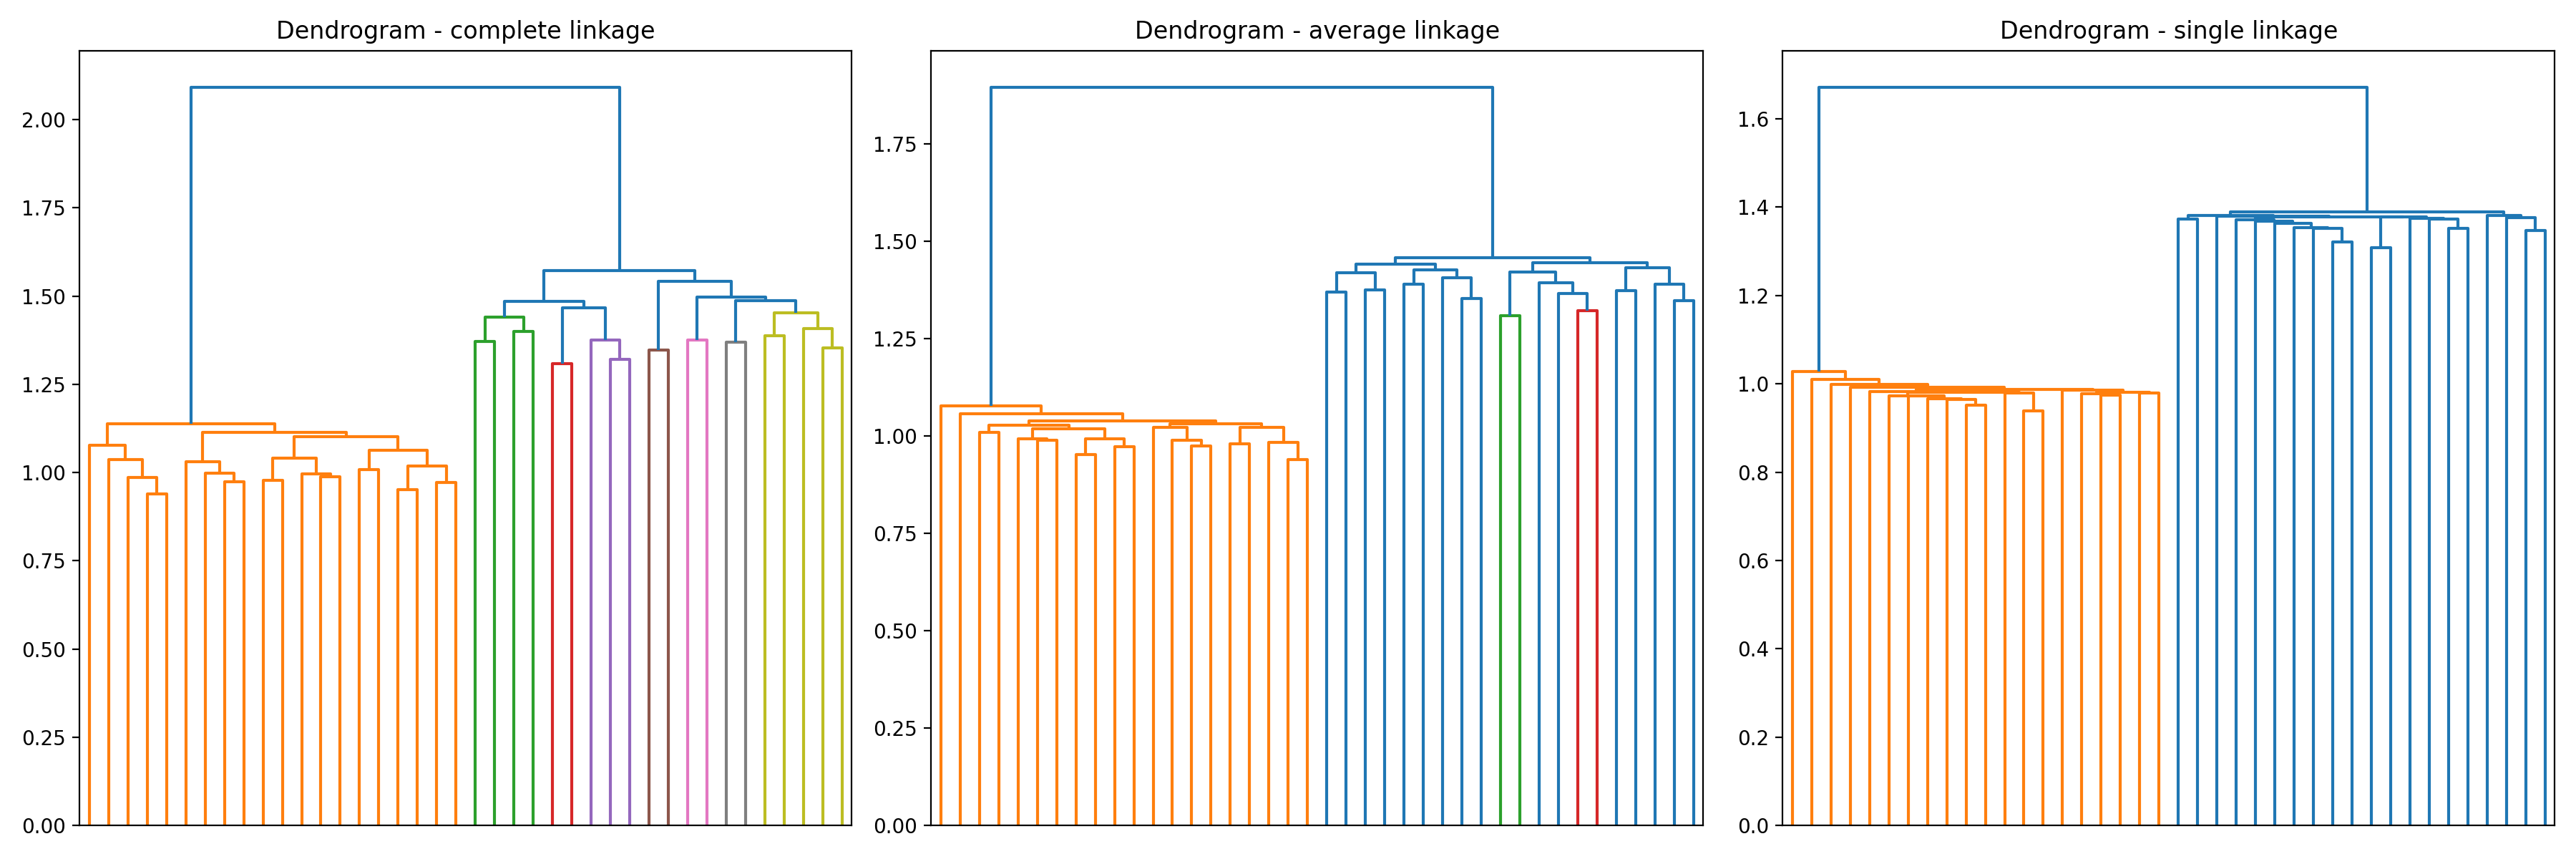

In [20]:
# Calculate the pairwise correlation-based distances between samples after transposing
correlation_distance_matrix = squareform(pdist(credit_data.T, metric='correlation'))

# Define linkage types
linkage_types = ['complete', 'average', 'single']

# Hierarchical clustering
plt.figure(figsize=(18, 6))
for i, linkage_type in enumerate(linkage_types, 1):
    # Perform hierarchical clustering using the current linkage type
    Z = linkage(correlation_distance_matrix, method=linkage_type)
    
    # Plot the dendrogram
    plt.subplot(1, len(linkage_types), i)
    dendrogram(Z, no_labels=True, leaf_rotation=90)
    plt.title(f'Dendrogram - {linkage_type} linkage')
    plt.tight_layout()
plt.show()

Your answer:

~~~
The dendrograms generated from hierarchical clustering with correlation-based distance do show a tendency to group samples, which could reflect the separation into healthy and diseased groups.

The clarity of this separation and the structure of the clusters indeed depend on the type of linkage used:

1. Complete linkage tends to form clusters by considering the maximum distance, which can lead to well-defined, distinct groups if such distances reflect the underlying separation between healthy and diseased samples.

2. Average linkage calculates the average distance between clusters, potentially offering a balanced view that might better capture the overall structure of the data, including any natural separation.

3. Single linkage forms clusters based on the shortest distance, which can result in a chaining effect that might not as clearly delineate compact groups or might exaggerate outlier effects.
~~~


(c) Your collaborator wants to know which genes differ the most
across the two groups. Suggest a way to answer this question,
and apply it here.

Your code:

Your answer:

~~~
Traditional way to do it is using t-test:

1. Separate the data into two groups: One for healthy samples (first 20 samples) and one for diseased samples (last 20 samples).

2. Apply the t-test for each gene: Perform an independent t-test for each gene to compare its expression levels between the two groups.

3. Identify significantly differentially expressed genes: Genes with adjusted p-values below a certain threshold (e.g., 0.05) can be considered differentially expressed.
~~~

In [23]:
# Separate the dataset into healthy and diseased groups
healthy_data = credit_data.iloc[:, :20]  # First 20 columns for healthy samples
diseased_data = credit_data.iloc[:, 20:]  # Last 20 columns for diseased samples

# Perform t-tests for each gene
p_values = [ttest_ind(healthy_data.iloc[i], diseased_data.iloc[i]).pvalue for i in range(credit_data.shape[0])]

# Adjust the p-values for multiple testing using the Benjamini-Hochberg method
adjusted_p_values = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')[1]

# Identify significantly differentially expressed genes
significantly_different_genes = np.where(adjusted_p_values < 0.05)[0]

# Print
number_of_significantly_different_genes = len(significantly_different_genes)
print(f"Number of significantly differentially expressed genes: {number_of_significantly_different_genes}")
print("Indices of the first 10 significantly differentially expressed genes:", significantly_different_genes[:10])

Number of significantly differentially expressed genes: 117
Indices of the first 10 significantly differentially expressed genes: [10 11 12 13 14 15 16 17 18 19]


## Additional Material

### pheatmap

pheatmap in R is popular in bioinformatics because it combines hierarchical clustering, heatmap, and k-means at once.  You can row cluster and column cluster at the same time. In python the closest you can find is in seaborn. https://seaborn.pydata.org/generated/seaborn.clustermap.html

In [ ]:
iris = datasets.load_iris()
iris_pd = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= ["sepal_length","sepal_width","petal_length","petal_width"] + ['Species'])
iris_pd["sample_id"]=    list(range(1,151)  )
iris_pd = iris_pd.set_index('sample_id')

my_palette = dict(zip(iris_pd["Species"].unique(), ["orange","yellow","brown"]))
row_colors = iris_pd["Species"].map(my_palette)
tmp=sns.clustermap(iris_pd,  method="ward", cmap="Blues", standard_scale=1, row_colors=row_colors)

### visualizing K-means result

There is nice visualization for k-means clustering.

In [ ]:
feature, target = make_blobs(n_samples=600,
                             centers=3,
                             random_state=123,
                             shuffle=True)

kmeansfit = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(feature)

df = pd.DataFrame({'x1': feature[:, 0], 'x2': feature[:, 1], 'target': target})
plt.scatter(df["x1"], df["x2"], alpha = 0.6, s=10)
plt.show()
df['cluster'] = kmeansfit.fit_predict(feature)# get centroids
centroids = kmeansfit.cluster_centers_
cen_x = [i[0] for i in centroids]
cen_y = [i[1] for i in centroids]
## add to df
df['cen_x'] = df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
df['cen_y'] = df.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
df['c'] = df.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})

fig, ax = plt.subplots(1, figsize=(8,8))
# plot data
plt.scatter(df["x1"], df["x2"], c=df.c, alpha = 0.3, s=10)

# plot centroids
plt.scatter(cen_x, cen_y, marker='*', c=colors, s=70)# plot Attack mean
plt.show()
#
# plt.plot([df.x1.mean()]*2, [-2,2], color='black', lw=0.5, linestyle='--')
# plt.xlim(-2,2)# plot Defense mean
# plt.plot([-2,2], [df.x2.mean()]*2, color='black', lw=0.5, linestyle='--')
# plt.ylim(-2,2)# create a list of legend elemntes
# ## average line
# legend_elements = [Line2D([0], [0], color='black', lw=0.5, linestyle='--', label='Average')]
# ## markers / records
# cluster_leg = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1),
#                markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
# ## centroids
# cent_leg = [Line2D([0], [0], marker='^', color='w', label='Centroid - C{}'.format(i+1),
#             markerfacecolor=mcolor, markersize=10) for i, mcolor in enumerate(colors)]
# # add all elements to the same list
# legend_elements.extend(cluster_leg)
# legend_elements.extend(cent_leg)
# # plot legend
# plt.legend(handles=legend_elements, loc='upper right', ncol=2)# title and labels
# #plt.title('Pokemon Stats\n', loc='left', fontsize=22)
# plt.xlabel('x1')
# plt.ylabel('x2')
# plt.show()

Another nice way to visualize K-means results when there are not too many k is the radar chart.
Returning to the USArrest example, we can use k-means and then inspect whether the clusters make sense.

In [ ]:
std_scaler = StandardScaler()

USArrests = pd.read_csv('USArrests.csv')#
USArrests=USArrests.rename(columns={"Unnamed: 0":"State"})
USArrests_kmeansfit = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(std_scaler.fit_transform(USArrests.loc[:,["Murder","Assault",  "UrbanPop",  "Rape"]]))

df = pd.DataFrame(USArrests_kmeansfit.cluster_centers_,columns=["Murder","Assault",  "UrbanPop",  "Rape"])
df["Cluster"]=list(range(1,6))
USArrests["Cluster"]=USArrests_kmeansfit.fit_predict(USArrests.loc[:,["Murder","Assault",  "UrbanPop",  "Rape"]])
# USA_cluster_mean=USArrests.loc[:,["Murder","Assault",  "UrbanPop",  "Rape","Cluster"]].groupby("Cluster").mean(numeric_only=True)
# USA_cluster_mean["Cluster"]=USA_cluster_mean.index
USA_x_m=pd.melt(df, id_vars=['Cluster'],
          value_vars=["Murder","Assault",  "UrbanPop",  "Rape"])
fig = px.line_polar(USA_x_m, r = 'value', theta = 'variable', line_close = True,
                    color = 'Cluster')
#fig.update_traces(fill = 'toself')

fig.show()


states = gpd.read_file('cb_2018_us_state_500k')

non_continental = ['HI','VI','MP','GU','AK','AS','PR']
us49 = states
for n in non_continental:
    us49 = us49[us49.STUSPS != n]
states=us49
# Assuming km.usA$cluster is your clustering result
# Replace the following line with your clustering result
km_usA_cluster = {'cluster': [0, 1, 2, 3], 'region': ['alabama', 'alaska', 'arizona', 'arkansas']}  # Sample data

# Convert km.usA$cluster to a DataFrame
dfft = pd.DataFrame(USArrests)

# Convert region names to lowercase to match with states data
dfft['region'] = dfft['State'].str.lower()

colors=sns.color_palette("husl",5).as_hex()

# Merge the states GeoDataFrame with the clustering results DataFrame
statec = states.merge(dfft, left_on='NAME', right_on='State', how='right')
statec['c'] = statec.Cluster.map({0:colors[0], 1:colors[1], 2:colors[2],3:colors[3],4:colors[4]})

fig, ax = plt.subplots(figsize=(10, 10))
fig.subplots_adjust(hspace=0.0, wspace=0.0)
statec.plot("Cluster", color=statec.c,legend=True,ax=ax)
xmin, ymin, xmax, ymax = states.total_bounds
pad = 5  # add a padding around the geometry
ax.set_xlim(xmin-pad, xmax+pad)
ax.set_ylim(ymin-pad, ymax+pad)
plt.show()

### Choice of the distance and linkage

Weird things happen for a particular choice of linkage methods.

This is an example where using the centroid flips.

In [ ]:
x=[5.24,4.58,6.25,6.15,5.02,5.95]
y=[3.16,2.78,2.24,4.04,3.99,2.77]
data = list(zip(x, y))

print(data)
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.scatter(x,y)
linkage_data = linkage(data, method='single', metric='euclidean')
dendrogram(linkage_data,ax=ax1)
linkage_data = linkage(data, method='centroid', metric='euclidean')
dendrogram(linkage_data,ax=ax2)
plt.show()

The different combinations will return different results.  Knowing that you cannot be ignorant about the method is essential.

### Other distances

There are many different distances and some are good for binary variables.
You can find most of them in `scipy.spatial.distance`
https://docs.scipy.org/doc/scipy/reference/spatial.distance.html#module-scipy.spatial.distance

- euclidean	$$d_{jk} = \sqrt{(\sum(x_{ij}-x_{ik})^2)}$$
	binary:$sqrt(A+B-2*J)$
- manhattan	$$d_{jk} = \sum(|x_{ij} - x_{ik}|)$$
	binary:$A+B-2*J$
- gower	$$d_{jk}  = \frac{1}{M} \sum\left(\frac{|x_{ij}-x_{ik}|}{(\max(x_{i})-\min(x_{i}))}\right)$$
	binary:$(A+B-2*J)/M$,
	where M is the number of columns (excluding missing values)
- altGower	$$d_{jk}  = ( \frac{1}{NZ} ) \sum(|x_{ij} - x_{ik}|)$$
	where $NZ$ is the number of non-zero columns excluding double-zeros (Anderson et al. 2006).
	binary:$(A+B-2*J)/(A+B-J)$
- canberra	$$d_{jk} = \frac{1}{NZ}  \sum \left(\frac{(x_{ij}-x_{ik})}{(x_{ij}+x_{ik})}\right)$$
	whereNZis the number of non-zero entries.
	binary:$(A+B-2*J)/(A+B-J)$
- bray	$$d_{jk}  = \left(\sum |x_{ij}-x_{ik}| \right)/\left(\sum (x_{ij}+x_{ik})\right)$$
	binary:$(A+B-2*J)/(A+B)$
- kulczynski	$$d_{jk} = 1 - 0.5*((\sum \min(x_{ij},x_{ik})/(\sum x_{ij}) + (\sum min(x_{ij},x_{ik})/(\sum x_{ik}))$$
	binary:$1-(J/A + J/B)/2$
- morisita	$$d_{jk} = 1 - 2*\frac{\sum\left(x_{ij}*x_{ik}\right)}{((\lambda_{j}+\lambda_{k}) * \sum(x_{ij})*\sum(x_{ik}))}$$, where
	$\lambda_{j} = \sum(x_{ij}*(x_{ij}-1))/\sum(x_{ij})*\sum(x_{ij}-1)$

	binary: cannot be calculated

- horn	$$d_{jk} = 1 - 2*\frac{\sum\left(x_{ij}*x_{ik}\right)}{((\lambda_{j}+\lambda_{k}) * \sum(x_{ij})*\sum(x_{ik}))}$$ ( Same as morisita ),
 but $$\lambda_{j} = \sum(x_{ij}^2)/(\sum(x[ij])^2)$$
	binary:$(A+B-2*J)/(A+B)$
- binomial	$$d_{jk} = \sum\left(x_{ij}*\log(\frac{x_{ij}}{n_{i}}) + x_{ik}*\log(\frac{x_{ik}}{n_{i}}) - n_{i}*\log( \frac{1}{2} )\right)/n_{i}$$,
	where $n_{i} = x_{ij} + x_{ik}$

	binary:$\log(2)*(A+B-2*J)$

- cao	$$d_{jk}  = \frac{1}{S} * sum(log(n_{i}/2) - (x_{ij}*\log(x_{ik}) + x_{ik}*\log(x_{ij}))/n_{i})$$,
	where $S$ is the number of species in compared sites and $n_{i} = x_{ij} + x_{ik}$

You can find these in the vegan package.

In [ ]:
pdist_Methods=['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'jensenshannon', 'kulczynski1', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']

xx = np.transpose(np.random.binomial(n=1, p=0.5, size=(1000, 100)))

from sklearn.metrics.pairwise import pairwise_distances
pairwise_distances(xx,metric="jaccard")

from scipy.spatial.distance import pdist
pdist(xx, 'euclidean')

### Cluster performance indices

There are various indices proposed for comparing the clustering result.
Few of the popular ones are implemented in `sklearn.metrics`
|----------------------------------|------------------------------------------------------
| ‘adjusted_mutual_info_score’     | metrics.adjusted_mutual_info_score
| ‘adjusted_rand_score’            | metrics.adjusted_rand_score
| ‘completeness_score’             | metrics.completeness_score
| ‘fowlkes_mallows_score’          | metrics.fowlkes_mallows_score
| ‘homogeneity_score’              | metrics.homogeneity_score
| ‘mutual_info_score’              | metrics.mutual_info_score
| ‘normalized_mutual_info_score’   | metrics.normalized_mutual_info_score
| ‘rand_score’                     | metrics.rand_score
| ‘v_measure_score’                | metrics.v_measure_score

Here is synthetic data with 6 clusters.

In [ ]:
from sklearn.datasets import make_blobs
feature, target = make_blobs(n_samples=600,
                             centers=6,
                             random_state=123,
                             shuffle=True)
mydata = pd.concat([pd.DataFrame(feature, columns=['x1', 'x2']), pd.DataFrame(target, columns=['y'])], axis=1)
plt.scatter(mydata["x1"], mydata["x2"])
plt.show()

If we manually calculate the WGSS

In [ ]:
from sklearn.cluster import KMeans

# Assuming `mydata` is a numpy array or pandas DataFrame containing your data
wss=np.zeros(15)
wss[0] = (mydata.shape[0] - 1) * np.sum(np.apply_along_axis(np.var, 0, mydata))

for i in range(2, 16):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init="auto")
    kmeans.fit(mydata)
    wss[i - 1] = kmeans.inertia_

plt.plot(range(1, 16), wss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Within groups sum of squares')
plt.title('Elbow Method')
plt.show()

The WGSS stops decreasing around K=5 to 6, which is correct for this problem.

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=0, n_init="auto")
kmeans.fit(mydata)
#mydata["cluster"]= kmeans.labels_
plt.scatter(mydata["x1"], mydata["x2"],c=kmeans.labels_)
plt.show()

#### [silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering))

Silhouette Scores are also popular metric to look at in clustering problem. Score near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
silhouette_avg = silhouette_score(mydata, kmeans.labels_)
sample_silhouette_values = silhouette_samples(mydata, kmeans.labels_)

ses=np.zeros(14)
for i in range(2, 16):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init="auto")
    kmeans.fit(mydata)
    ses[i - 2] = silhouette_score(mydata, kmeans.labels_)


plt.plot(range(1, 15), ses, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Analysis')
plt.show()

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7]

n_clusters=6
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(mydata) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(mydata)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(mydata, cluster_labels)
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(mydata, cluster_labels)

y_lower = 10


for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()
    import matplotlib.cm as cm
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples


ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    mydata.loc[:, "x1"],mydata.loc[:, "x2"], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % n_clusters,
    fontsize=14,
    fontweight="bold",
)

plt.show()

### Partitioning Around Medoids
K-Medoids or Partitioning (clustering) of the data into k clusters “Around Medoids” (PAM) is a more robust version of K-means.

In [ ]:
#pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

kmedoids = KMedoids(n_clusters=3, random_state=0).fit(iris.data)
kmedoids.labels_
kmedoids.cluster_centers_
kmedcrsstab = pd.crosstab(index=iris.target,
                           columns=kmedoids.labels_)

### Mclust

Mclust is an R package with a collection of model based clustering methods.  mclustpy is the python rapper of the R package.

In [ ]:
# pip install rpy2
# pip install mclustpy
from mclustpy import mclustpy
mc = mclustpy(iris.data, G=9, modelNames='EEE', random_seed=2020)
mc['classification']

### Unsupervised Learning for Timeseries

Working with timeseries data in Unsupervised Learning situations poses several unique challenges.
The naive way of treating observations along time as a set of features works well only when the timeseries' are well aligned.
For many realistic situations, this is not necessarily the case. Even in a situation where the comparison is about the aligned timeseries, there are problems such as missing data and misalignment of the starting times that need treatment.
https://github.com/aapatel09/handson-unsupervised-learning/blob/master/13_temporal_clustering.ipynb
To make the point, here is CO2 emission by country.

In [ ]:
# pip install openpyxl
#https://github.com/opencasestudies/ocs-bp-co2-emissions/tree/master/data/raw
CO2_emissions = pd.read_excel("yearly_co2_emissions_1000_tonnes.xlsx")
CO2_emissions_subset=CO2_emissions[CO2_emissions.country.isin(["United States","Canada","China","United Kingdom","France","India"])]
memm=pd.melt(CO2_emissions_subset, id_vars=['country'])
#as.integer(as.character(variable))
(
  ggplot(memm)+geom_point()+geom_line()+
  aes(x="variable",y="value",color="country")+
  scale_y_log10()+xlab("year")+ylab("Co2 Emission") +
  theme(axis_text_x = element_text(angle = 45, hjust = 1, vjust = 1))
)

Let's say you want to cluster the countries by their trend.  The time is aligned since each country has the same years.
However, you can see that the measurement goes back much longer in time for UK than other countries. Also there are gaps in the measurements that need to be taken care of.  One way to deal with such data is to limit your observations to years that are more stable.

In [ ]:
memm2000=memm[memm.variable>2000]
(
  ggplot(memm2000)+
  geom_point()+geom_line()+
  aes(x="variable",y="value",color="country",group="country")+
  scale_y_log10()+xlab("year")+ylab("Co2 Emission")
)

Another example is to determine the letter being written from the trajectories of a writer. Below are lines for five examples of the X velocity for A and B.
https://archive.ics.uci.edu/dataset/175/character+trajectories

In [ ]:
CharTraj=pd.read_csv("CharTraj.csv")
plt.plot(range(0,203), CharTraj.iloc[0,2:205])
plt.plot(range(0,203), CharTraj.iloc[1,2:205])
plt.plot(range(0,203), CharTraj.iloc[2,2:205])
plt.plot(range(0,203), CharTraj.iloc[3,2:205])
plt.plot(range(0,203), CharTraj.iloc[4,2:205])
plt.show()
plt.plot(range(0,203), CharTraj.iloc[5,2:205])
plt.plot(range(0,203), CharTraj.iloc[6,2:205])
plt.plot(range(0,203), CharTraj.iloc[7,2:205])
plt.plot(range(0,203), CharTraj.iloc[8,2:205])
plt.plot(range(0,203), CharTraj.iloc[9,2:205])
plt.show()
# import scipy.io
# CharTraj = scipy.io.loadmat('character_trajectories/mixoutALL_shifted.mat')
# from matplotlib.lines import Line2D
# plt.plot(range(0,178), CharTraj.get("mixout")[0][1][1,:])
# Line2D(range(0,178), CharTraj.get("mixout")[0][2][1,:])
# Line2D(range(0,178), CharTraj.get("mixout")[0][3][1,:])
# Line2D(range(0,178), CharTraj.get("mixout")[0][4][1,:])
# Line2D(range(0,178), CharTraj.get("mixout")[0][6][1,:])
# plt.show()
#
# plt.plot(range(0,130), CharTraj.get("mixout")[0][174][1,:])
# plt.plot(range(0,130), CharTraj.get("mixout")[0][175][1,:])
# plt.plot(range(0,130), CharTraj.get("mixout")[0][176][1,:])
# plt.plot(range(0,130), CharTraj.get("mixout")[0][177][1,:])
# plt.plot(range(0,130), CharTraj.get("mixout")[0][178][1,:])
# plt.show()
#
# (CharTraj.get("consts")[0][0][3])
# pd.DataFrame(CharTraj.get("consts")[0][0][4][0]).value_counts().sort_index()

This will be a whole timeseries comparison within fixed time window, but you have a misalignment in time that would distort point-by-point distance.

Suppose the goal is to extract particular activity from measurements taken on a wearable device and to classify what is being done. In that case, an additional segmentation issue must be considered.

#### Dynamic Time Warping (DTW)

Dynamic Time warping is a way to calculate distances between datapoints when the datapoints are shifted horizontally in time between each other, but the shape is consistent.  Unlike Euclidean distance, for DTW, the two time series do not have to have an equal length. DTW calculates the smallest distance between all points and then finds the closest matching points.  Here is an illustration of how it works. (https://rpubs.com/esobolewska/dtw-time-series)

In [ ]:
# pip install dtw-python # you will need to install
from dtw import dtw as dtwpy_dtw
from dtw import *
#pip install dtaidistance # you will need to install
from dtaidistance import dtw as dtad_dtw
#pip install tslearn # you will need to install
# from tslearn.metrics import dtw as ts_dtw

## A noisy sine wave as query
idx = np.linspace(0,6.28,num=100)
query = np.sin(idx) + np.random.uniform(size=100)/10.0

## A cosine is for template; sin and cos are offset by 25 samples
template = np.cos(idx)

a1 = query# np.array([7, 9, 6, 9, 12, 6, 4, 6, 8])
a2 = template#np.array([5, 6, 4, 3, 9, 5, 6, 8, 9])

# Calculate Dynamic Time Warping (DTW)
dtad_distance = dtad_dtw.distance(a1, a2)
#ts_distance   = ts_dtw(a1, a2) # problem with reticulate
#
ptwpy_distance = dtwpy_dtw(a1, a2, keep_internals=True)

## Display the warping curve, i.e. the alignment curve
ptwpy_distance.plot(type="threeway")

# Plotting
xrange = [np.min(a1),np.max(a1)+1]
yrange = [np.min(a2), np.max(a2)+ 1]

plt.plot(xrange, yrange, color='white')  # Set up the plot
plt.plot(a1, color='blue', linestyle='-')  # Plot a1
plt.plot(a2, color='magenta', linestyle='-')  # Plot a2
plt.xlabel('time')
plt.ylabel('value')
plt.show()

In [ ]:
dtw(a1, a2, keep_internals=True,
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)
plt.show()
## See the recursion relation, as formula and diagram
print(rabinerJuangStepPattern(6,"c"))
rabinerJuangStepPattern(6,"c").plot()

using pyts library

In [ ]:
#pip install pyts # you will need to install
from pyts.metrics import dtw as pyts_dtw

pyts_distance = pyts_dtw(a1, a2) # problem with reticulate
n_timestamps_1, n_timestamps_2 = a1.size,a2.size

plt.figure(figsize=(10, 8))
timestamps_1 = np.arange(n_timestamps_1 + 1)
timestamps_2 = np.arange(n_timestamps_2 + 1)

# Dynamic Time Warping: classic
dtw_classic, path_classic = pyts_dtw(a1, a2, dist='square',
                                method='classic', return_path=True)
matrix_classic = np.zeros((n_timestamps_1, n_timestamps_2))
matrix_classic[tuple(path_classic)] = 1.

plt.subplot(2, 2, 1)
plt.pcolor(timestamps_1, timestamps_2, matrix_classic.T,
           edgecolors='k', cmap='Greys')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("{0}\nDTW(x, y) = {1:.2f}".format('classic', dtw_classic),
          fontsize=14)
plt.show()
# plot(dtwfit, xlab="a1 - blue", ylab="a2 - magenta",
#      xaxp  = c(0,10,10), yaxp = c(0,10,10), type="threeway")
# plot(dtwfit, xaxp  = c(0,10,10), yaxp = c(0,10,10), type="twoway", col=c('blue', 'magenta'))

tslearn.clustering has few useful functions.
But for some reason it does not work with Rstudio

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import KShape
scaler = StandardScaler()
co2emissions_norm=pd.DataFrame(scaler.fit_transform(CO2_emissions.iloc[:,254:265].dropna()),columns=CO2_emissions.iloc[:,254:265].columns)

N_CLUSTERS=5
model = TimeSeriesKMeans(n_clusters=N_CLUSTERS, metric="dtw",
                         max_iter=10, random_state=1234)
model.fit(co2emissions_norm)
y_pred = model.predict(co2emissions_norm)
plt.figure()
#plt.subplots(figsize = (20, 16))
for yi in range(N_CLUSTERS):
    plt.subplot(10, 6, yi + 1)
    tempx=co2emissions_norm[y_pred == yi]
    for xx in range(0,tempx.shape[0]):
        plt.plot(tempx.iloc[xx,:].ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")
    plt.show()




For the hand writing data.

In [ ]:
CharTraj_fill=CharTraj.iloc[:,2:205].fillna(0)
kshape=KShape(n_clusters=20,
                         max_iter=10, random_state=1234)
kshape.fit(CharTraj_fill)
# hc <- tsclust(CharTraj, type = "hierarchical", k = 20L,
#               distance = "sbd", trace = TRUE,
#               control = hierarchical_control(method = "average"))
# plot(hc)


# tdf<-melt(CharTraj) # %>% group_by(L1) %>% mutate(id = row_number())
# tcf<-melt(hc@cluster)
# tcf$L1<-rownames(tcf)
# tdf<-merge(tdf,tcf,by ="L1")
# tdf$num <- sequence(rle(tdf$L1)$lengths)
# ggplot(tdf)+geom_line(aes(x=num,y=value.x,group=L1))+facet_wrap(~value.y)

### DBScan

The DBScan clustering algorithm is as follows:

1. Randomly select a point i.
2. Retrieve all the points that are density reachable from i concerning the Maximum radius of the neighborhood (EPS) and the minimum number of points within eps neighborhood(Min Pts).
3. If the number of points in the neighborhood is more than Min Pts then i is a core point.
4. For i core points, a cluster is formed. If i is not a core point, mark it as a noise/outlier and move to the next point.
5. Continue the process until all the points have been processed.

In [ ]:
from sklearn.cluster import DBSCAN

from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
clustering = DBSCAN(eps=0.45, min_samples=5).fit(iris.data)

# Checking cluster
labels=clustering.labels_

# Table
crsstab = pd.crosstab(index=iris.target,
                           columns=clustering.labels_)

# Plotting Cluster

unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True

plt.scatter(iris.data[:, 2], iris.data[:, 3])
plt.show()
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = iris.data[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 2],
        xy[:, 3],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = iris.data[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 2],
        xy[:, 3],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

#plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

### Other dimension reduction techniques

Various other dimension reduction techniques have been popularized over the years.

####  t-distributed stochastic neighbor embedding (t-SNE)

First is [t-SNE](https://lvdmaaten.github.io/tsne/) by L.J.P. van der Maaten and G.E. Hinton (2008). The algorithm projects the high-dimensional data points into low dimension (2D) by inducing the projected data to have a similar distribution as the original data points by minimizing KL divergence.

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(fm.iloc[1:200,1:785])
X_embedded.shape


fig = px.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1], color=fm.iloc[1:200,0])
fig.update_layout(
    title="t-SNE visualization of Custom Classification dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
#fig.show()

#### Uniform Manifold Approximation (UMAP)

UMAP is another dimension reduction described by McInnes and Healy (2018) in <arXiv:1802.03426>.

https://umap-learn.readthedocs.io/en/latest/basic_usage.html


In [ ]:
#pip install tensorflow
#pip install umap-learn
#import tensorflow
#fm=tensorflow.keras.datasets.fashion_mnist.load_data()
import umap
from sklearn.datasets import load_digits
digits = load_digits()
fig, ax_array = plt.subplots(20, 20)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray_r')


plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)
plt.show()

digits_df = pd.DataFrame(digits.data[:,1:11])
digits_df['digit'] = pd.Series(digits.target).map(lambda x: 'Digit {}'.format(x))
sns.pairplot(digits_df, hue='digit', palette='Spectral');

reducer = umap.UMAP(random_state=42)
reducer.fit(digits.data)
embedding = reducer.transform(digits.data)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=24);
plt.show()

### Using H2O for Unsupervised Learning

In [ ]:
import h2o
h2o.init()

In [ ]:
# Import the birds dataset into H2O:
birds = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/pca_test/birds.csv")

#### PCA

H2O uses the power method to calculate the singular value decomposition of the Gram matrix.
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/pca.html

In [ ]:
from h2o.estimators import H2OPrincipalComponentAnalysisEstimator

# Split the dataset into a train and valid set:
train, valid = birds.split_frame(ratios = [.8], seed = 1234)

# Build and train the model:
birds_pca = H2OPrincipalComponentAnalysisEstimator(k = 5,
                                                   use_all_factor_levels = True,
                                                   pca_method = "glrm",
                                                   transform = "standardize",
                                                   impute_missing = True)
birds_pca.train(training_frame = train)

# Generate predictions on a validation set (if necessary):
pred = birds_pca.predict(valid)

#### K-means

https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/k-means.html

In [ ]:
from h2o.estimators import H2OKMeansEstimator
# Build and train the model:

# Import the iris dataset into H2O:
iris = h2o.import_file("http://h2o-public-test-data.s3.amazonaws.com/smalldata/iris/iris_wheader.csv")

# Set the predictors:
predictors = ["sepal_len", "sepal_wid", "petal_len", "petal_wid"]
# Split the dataset into a train and valid set:
train, valid = iris.split_frame(ratios=[.8], seed=1234)


iris_kmeans = H2OKMeansEstimator(k=10,
                                 estimate_k=True,
                                 standardize=False,
                                 seed=1234)
iris_kmeans.train(x=predictors,
                  training_frame=train,
                  validation_frame=valid)

# Eval performance:
perf = iris_kmeans.model_performance()

#  Generate predictions on a validation set (if necessary):
pred = iris_kmeans.predict(valid)

#### Shut down H2O

In [ ]:
h2o.cluster().shutdown(prompt =False)